# Does Taking Advanced Classes in High School Influence A Student's College Performance?
Authors: Derek So, Kaitlyn Huynh, Tyson Tran, Michael Nicodemus

# Question

Is there a correlation between having taken advanced courses (AP and IB) during high school and grade point average during college in the United States?

Hypothesis: The more AP or IB courses a student has taken, the higher their college grade point average will be.


# Data

Include the code to read your dataset in below and briefly explain what information is included in your dataset that you'll use for analysis.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

import seaborn as sns; sns.set(color_codes=True)
import patsy
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
df = pd.read_csv('cogs9_survey.csv')

Our data comes from a survey we put out, which garnered 141 responses. 2 responses were removed due to coming from invalid sources, the former who reported that they have yet to attend college and the latter who did not report their college. The data in the column "What university/college are you attending" was cleaned prior to loading in the csv as it was simpler to modify the text that way. Below is the first response.

In [3]:
df.iloc[0:1]

,Timestamp,Did you take AP or IB classes in high school?,Which did you take?,Number of AP or IB classes taken,GPA in High School (Non-Weighted),What university/college are you attending?,What year are you?,GPA in College
0,11/7/2019 16:33:04,Yes,AP,9,3.84,UCSD,Year 3 (Junior),3.53


Timestamp was the moment the survey was taken. Such data is irrelevant to our project and will be removed.

Did you take AP or IB classes in high school?: This question is largely redundant, as the two next questions provide data that answers this question. However, besides the standard Yes/No answer data to this question, there was a third option of APs/IBs were not available, allowing us to account for those who could not take those classes not out of choice, but because it was not possible.

Which did you take?: The options here were 'AP', 'IB', and 'Both', and 'Neither.' With this, we can compare those who took APs and those who tooks IBs.

Number of AP or IB classes taken: The data provided by this question is discrete and should largely be normally distributed, though some extreme outliers exist on the upper end.

GPA in High School (Non-Weighted): This data ranges from 0 to 4 and will be compared to College GPA. 

What university/college are you attending?: Given enough data for a school to be statistically valid, we can compare the gpa correlations of high school to different colleges. All data here has been simplified to acronyms or a word, to which the key will be provided later as necessary.

What year are you?: With this variable, we may explore if the person's current year in college is a confounding variable in their GPA, as the GPAs we are comparing are not equivalent—high school gpas have been 'complete', while those in freshman year taking this survey may not even have a college GPA yet. We gave 5 options, 1 through 4 then 5+ for years in college so far.

GPA in College: This data ranges from 0 to 4 will be compared to GPA in High School.

# Data Wrangling

Include text and code needed to wrangle your data into a tidy data format. If your data are already in a usable format, explain what checks you did on the data (and include the code) to ensure that the data were tidy.

First, we may rename the variables to something simpler. We also remove the extraneous timestamp variable which was automatically logged by the google form as we have no use for it.

In [4]:
#rename variables
df.rename(index=str,columns={"Did you take AP or IB classes in high school?":"TAKE",
                             "Which did you take?":"WHICH",
                             "Number of AP or IB classes taken":"AMOUNT",
                             "GPA in High School (Non-Weighted)":"HSGPA",
                             "What university/college are you attending?":"UNI",
                             "What year are you?":"YEAR",
                             "GPA in College":"UNIGPA"
                            },
          inplace = True)

#remove timestamp
df = df.filter(["TAKE","WHICH","AMOUNT","HSGPA","UNI","YEAR","UNIGPA"])

#display
df.iloc[0:1]

,TAKE,WHICH,AMOUNT,HSGPA,UNI,YEAR,UNIGPA
0,Yes,AP,9,3.84,UCSD,Year 3 (Junior),3.53


Next, we shall list what values are in each column, line by line.

In [5]:
print("TAKE =", df.TAKE.unique())
print("WHICH =", df.WHICH.unique())
print("AMOUNT =", df.AMOUNT.unique())
print("HSGPA =", df.HSGPA.unique())
print("UNI =", df.UNI.unique())
print("YEAR =", df.YEAR.unique())
print("UNIGPA =", df.UNIGPA.unique())

TAKE = ['Yes' 'No' 'AP/IB was not available']
WHICH = ['AP' 'None' 'IB' 'Both']
AMOUNT = [ 9  5  7  6  4  2 12 10  1  8 13 11  0  3 14 21 17 16]
HSGPA = [3.84 3.9  3.87 3.83 3.5  3.64 3.7  2.7  4.5  4.25 4.   4.33 3.6  2.9
 3.4  3.   3.8  3.2  3.85 3.3  3.95 2.6  1.9  3.98 3.33 3.89 3.86 3.73
 3.88 2.   3.97 3.65 3.1  3.92 3.78 2.5  3.94 2.8  3.45 3.68]
UNI = ['UCSD' 'UC Berkeley' 'PCC' 'SDMC' 'UCR' 'UTexas (Austin)' 'UCSC ' 'CSUDH'
 'SWC' 'Holy Cross' 'SDSU' 'UCLA' 'UCSB' 'SFSU' 'Grossmont' 'UC Berkeley '
 'UCI' 'Crafton Hills' 'APU' 'CSULB' 'HWC' 'CGCC' 'TESC' 'CSUF' 'IVC'
 'WPI' 'GWC' 'CCSF' 'Pierce ' 'Cypress' 'OCC']
YEAR = ['Year 3 (Junior)' 'Year 2 (Sophomore)' 'Year 4 (Senior)'
 'Year 1 (Freshman)' 'Year 5 or more']
UNIGPA = [3.53  3.87  3.48  3.01  3.    3.95  3.2   3.4   3.7   3.6   4.    2.9
 3.35  2.3   3.1   2.5   3.55  2.    0.    3.34  3.75  2.8   3.559 1.8
 3.895 3.26  1.93  3.5   3.9   3.61  3.8   3.58  3.56  3.44  3.042 2.6
 2.79  2.063 3.86  3.67  3.57  3.91  3.28  3.

We shall shorten 'AP/IB was not available' to 'Neither Available', and since reported HSGPA values are nonweighted, we will fix misreported values of over 4 by capping the values to 4. We will also change all the values in YEAR to 1 through 5, as we had the responses formatted that way previously in a multiple choice in order to prevent confusion. Also, we remove one person who logged the UNIGPA of 0, as that was likely an input error but would skew the data.

In [6]:
#replace specific values
df = df.replace(['AP/IB was not available','Year 1 (Freshman)','Year 2 (Sophomore)','Year 3 (Junior)','Year 4 (Senior)','Year 5 or more'],
            ['Neither Available',1,2,3,4,5])

#replace values in HSGPA above 4 with 4
df['HSGPA'] = df['HSGPA'].clip_upper(4)

#remove the person with a UNIGPA of 0
df = df.loc[df['UNIGPA']!=0]

C:\Users\derek\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  


In [7]:
print("TAKE =", df.TAKE.unique())
print("max HSGPA =", max(df.HSGPA.unique()))
print("YEAR =", df.YEAR.unique())

TAKE = ['Yes' 'No' 'Neither Available']
max HSGPA = 4.0
YEAR = [3 2 4 1 5]


In [8]:
df.iloc[0:10]

,TAKE,WHICH,AMOUNT,HSGPA,UNI,YEAR,UNIGPA
0,Yes,AP,9,3.84,UCSD,3,3.53
1,Yes,AP,5,3.90,UCSD,3,3.87
2,Yes,AP,7,3.87,UCSD,3,3.48
3,Yes,AP,6,3.83,UC Berkeley,3,3.01
4,Yes,AP,5,3.50,PCC,3,3.00
5,Yes,AP,5,3.64,SDMC,2,3.95
6,Yes,AP,4,3.70,UCR,3,3.20
7,Yes,AP,2,2.70,UCSD,3,3.40
8,Yes,AP,7,4.00,UCSD,4,3.70
9,Yes,AP,6,3.90,UC Berkeley,4,3.60


# Data Analysis

First, we summarize the data.

In our survey, the vast majority of the participants took advanced classes. Thus, we cannot accurately compare the two.

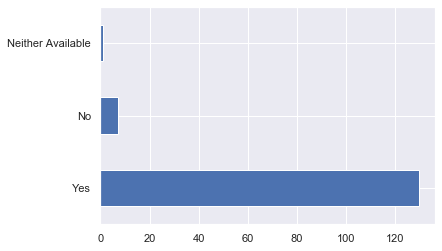

In [9]:
df['TAKE'].value_counts().plot(kind='barh')

Moreover, most of those people took AP classes, with very few taking IB classes or both, so again we cannot accurately compare those who took AP against those who took IB.

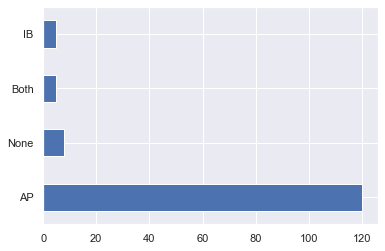

In [10]:
df['WHICH'].value_counts().plot(kind='barh')

Now we explore the distribution of the amount of advanced classes taken per person. The data is relatively normal with a slight skew to the right, with one interpid student having taken 21 advanced classes. However, the majority of people took between four and nine advanced classes, and more people took fewer than that rather than more.

In [11]:
print(max(df['AMOUNT'])-min(df['AMOUNT']))

21


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FEC237E5C0>]],
      dtype=object)

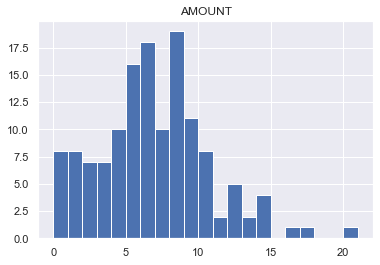

In [12]:
df.hist('AMOUNT',bins=21)

Here, we first find the range of the GPA values so that we may bin the values in increments of .1. Here we find that about half of those surveyed had a GPA in the highest bin, and approximately four fifths had 3.8 or greater GPA.

In [13]:
print(max(df['HSGPA'])-min(df['HSGPA']))

2.1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FEC245C748>]],
      dtype=object)

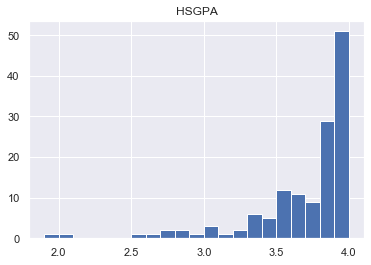

In [14]:
df.hist('HSGPA',bins=21)

Here we logged which college the participant attended. We gathered most of the data from UCSD, and hoped to compare to other colleges, but given the imbalance in the distribution, such an analysis is not possible. The acronym to full name table may be found here on Sheet 2 (along with the original survey csv): https://docs.google.com/spreadsheets/d/1hTpEO2KMcnBLy1Te-6ofRgLsV6M_60tuRAXmdoIsUVU/edit?usp=sharing 

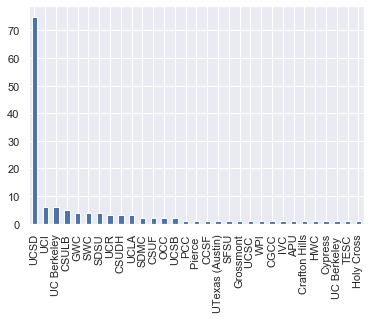

In [15]:
df['UNI'].value_counts().plot(kind='bar')

We also logged which year of college the participant is currently in. This will be used to check for confounds, as it is possible that those in earlier years of college have higher gpas due to easier classes or fewer classes taken. The majority of our participants are in their second year.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FEC243AF98>]],
      dtype=object)

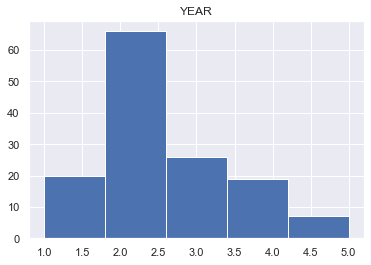

In [16]:
df.hist('YEAR',bins=5)

Again, we use the range of the GPA to bin the data to increments of .1. Overall, the university GPAs are much more evenly distributed, with the bulk of the data still in the upper end but not as concentrated in the highest bin.

In [17]:
print(max(df['UNIGPA'])-min(df['UNIGPA']))

2.7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FEC26BA320>]],
      dtype=object)

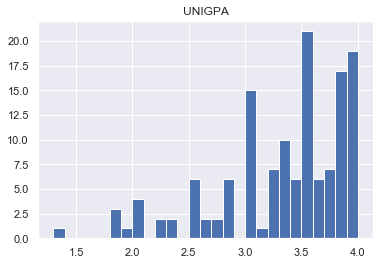

In [18]:
df.hist('UNIGPA',bins=27)

Now for the analysis: first, we shall simply graph the scatter plot of the amount of advanced classes taken to college GPA. Here we see an obviously positive relationship, with an increase of GPA of .04 for every advanced class taken. Even though there is an apparent pattern in the graph, though, given the r_value of .27, this relationship is fairly weak.

slope: 0.041461889766023545
r_value: 0.2689657810194567


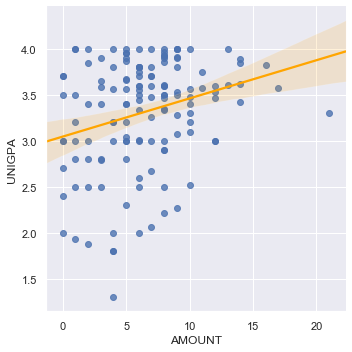

In [19]:
sns.lmplot(x='AMOUNT',y='UNIGPA',data=df,
           line_kws={'color':'orange'})

slope, intercept, r_value, p_value, std_err = stats.linregress(df["AMOUNT"],df["UNIGPA"])
print("slope:",slope)
print("r_value:",r_value)

Here we arrange the data into a pivot table to find the average UNIGPA value per AMOUNT. We can see the average is generally above 3.0, with the exception at AMOUNT == 4, with no obvious upward or downward trend as AMOUNT increases.

In [20]:
pv_HSGPA = pd.pivot_table(df, values='HSGPA', index=['AMOUNT'])
pv_HSGPA

,HSGPA
AMOUNT,
0,3.087500
1,3.137500
2,3.458571
3,3.571429
4,3.582000
5,3.651250
6,3.754444
7,3.919000
8,3.866842


In [21]:
pv_UNIGPA = pd.pivot_table(df, values='UNIGPA', index=['AMOUNT'])
pv_UNIGPA

,UNIGPA
AMOUNT,
0,3.000000
1,3.116250
2,3.060000
3,3.231429
4,2.765900
5,3.419375
6,3.377222
7,3.327300
8,3.423474


Then we use a linear model to check whether the amount of classes taken predicts university GPA, and in this case we check the p-value to see if this prediction is statistically significant. Our alpha value of significance is set to .05.

In [22]:
#Linear Model for UNIGPA
outcome_1, predictors_1 = patsy.dmatrices('UNIGPA ~ AMOUNT', df)
mod_1 = sm.OLS(outcome_1, predictors_1)
type(mod_1)
res_1 = mod_1.fit()

#Does AMOUNT predict UNIGPA?
print("p value:",res_1.pvalues[1])
print("Does the amount of advanced classes taken predict the university GPA?")
print(res_1.pvalues[1] <= 0.05)

p value: 0.0014232861530786315
Does the amount of advanced classes taken predict the university GPA?
True


However, using this more advanced predictor, we can also check confounds. Below we check whether the amount of advanced classes taken still predict the student's university GPA given their current year in university, and then check the same given their high school GPA.

In [23]:
#Linear Model for UNIGPA to AMOUNT + YEAR
outcome_2, predictors_2 = patsy.dmatrices('UNIGPA ~ AMOUNT + YEAR', df)
mod_2 = sm.OLS(outcome_2, predictors_2)
type(mod_2)
res_2 = mod_2.fit()

#Does AMOUNT still predict UNIGPA given YEAR?
print("p value:",res_2.pvalues[1])
print("Given year of college, does the amount of advanced classes taken predict the university GPA?")
print(res_2.pvalues[1] <= 0.05)

p value: 0.0011867718631247935
Given year of college, does the amount of advanced classes taken predict the university GPA?
True


In [24]:
#Linear Model for UNIGPA to AMOUNT + HSGPA
outcome_3, predictors_3 = patsy.dmatrices('UNIGPA ~ AMOUNT + HSGPA', df)
mod_3 = sm.OLS(outcome_3, predictors_3)
type(mod_3)
res_3 = mod_3.fit()

#Does AMOUNT still predict UNIGPA given HSGPA?
print("p value:",res_3.pvalues[1])
print("Given high school GPA, does the amount of advanced classes taken predict the university GPA?")
print(res_3.pvalues[1] <= 0.05)

p value: 0.07172807802302794
Given high school GPA, does the amount of advanced classes taken predict the university GPA?
False


Apparently, given the high school GPA, the amount of advanced classes taken no longer becomes a statistically sound predictor. This is more apparent when we graph HSGPA with UNIGPA and check the r-value of that relationship, which is a slightly stronger value of ~.3. The overall relationship between HSGPA and UNIGPA is weak, but it is still a better predictor than AMOUNT.

slope: 0.4475210797133376
r_value: 0.29825418601401027


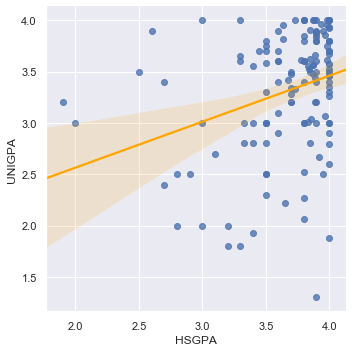

In [25]:
sns.lmplot(x='HSGPA',y='UNIGPA',data=df,
           line_kws={'color':'orange'})

slope, intercept, r_value, p_value, std_err = stats.linregress(df["HSGPA"],df["UNIGPA"])
print("slope:",slope)
print("r_value:",r_value)

# Conclusion

It should be noted that our analysis does not include factors such as how educationally rigorous the institutions the student attends are. After all, it is logically more difficult to achieve a higher GPA at an university like Harvard than your typical city college, and high schools can also vary. Our data mainly pertains to a small dataset, of which mostly contains UCSD students. These results are likely biased and very limited, but nonetheless ... 

In conclusion, our hypothesis was correct. The amount of advanced classes a student has taken does predict their college GPA. The relationship is relatively weak, but it is there. However, other factors are better predictors of college GPA than the amount of advanced classes taken, namely, as we discovered, the student's high school GPA.

# Programming Experience

Derek is proficient in programming, having taken CSE11, DSC10, and COGS108 prior to this class. As he has completed a very similar project before, he has learned how to lead others with his greater experience with coding.

Tyson did not have any Python experience until the start of this quarter where he learned Python in DSC10 with the Data Science package. He learned how to read tables and create scatter plots with the Pandas package by looking at the documentation.

Kaitlyn had no prior experience in Python. By completing the extra credit, she learned that even self-collected data has to be cleaned out in a way that would be computer readable and maximize efficiency of finding results from the data. Data wrangling is a very important part of any data experiment and should take up a large amount of a data scientist’s time, because the attention to detail put into data wrangling will largely affect the results of the experiment. 

Michael has had minimal programming experience in Python prior to this project as most of his programming experience was in Java throughout high school. After completing the extra credit, he learned how to generate histograms using the Pandas module.
